In [148]:
from tokenizers import Tokenizer
import transformers
from bart_spektro.modeling_bart_spektro import BartSpektroForConditionalGeneration
from bart_spektro.configuration_bart_spektro import BartSpektroConfig
from data_utils import SpectroDataCollator, SpectroDataset
import torch
from metrics import compute_cos_simils, SpectroMetrics
from train_bart import build_tokenizer
from pathlib import Path

# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
def build_tokenizer(tokenizer_path: str) -> transformers.PreTrainedTokenizerFast:
    bpe_tokenizer = Tokenizer.from_file(tokenizer_path)

    tokenizer = transformers.PreTrainedTokenizerFast(tokenizer_object=bpe_tokenizer,
                                        bos_token="<bos>",
                                        eos_token="<eos>",
                                        unk_token="<ukn>",
                                        pad_token="<pad>",
                                        is_split_into_words=False)
    return tokenizer

In [147]:
tokenizer_path = "tokenizer/bbpe_tokenizer/bart_bbpe_1M_tokenizer.model"
bpe_tokenizer = Tokenizer.from_file(tokenizer_path)
tokenizer = build_tokenizer(tokenizer_path)

In [149]:
type(tokenizer)

transformers.tokenization_utils_fast.PreTrainedTokenizerFast

In [150]:
tokenizer.special_tokens_map

{'bos_token': '<bos>',
 'eos_token': '<eos>',
 'unk_token': '<ukn>',
 'pad_token': '<pad>'}

In [156]:
a = tokenizer.convert_tokens_to_ids("<bos>")
print(a)

3


In [139]:
pred_smiles = "<bos><nist> Clc1ccc(c(c1)Cl)c1ccc(cc1)OC(=O)c1sccc1S(=O)(=O)N(C)C<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>"
gt_smiles = "<nist> Cc1cc2c(c(=S)[nH]1)C(=O)OC2=Cc1ccc(Cl)c(Cl)c1<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>"

pred_ids = tokenizer.encode(pred_smiles)
gt_ids = tokenizer.encode(gt_smiles)
pred_smiles, gt_smiles = tokenizer.decode(pred_ids, skip_special_tokens=True), tokenizer.decode(gt_ids, skip_special_tokens=True)
pred_smiles, gt_smiles


# pred_ids = torch.tensor(pred_ids).unsqueeze(0)
# gt_ids = torch.tensor(gt_ids).unsqueeze(0)

# pred_ids, gt_ids

(' Clc1ccc(c(c1)Cl)c1ccc(cc1)OC(=O)c1sccc1S(=O)(=O)N(C)C',
 ' Cc1cc2c(c(=S)[nH]1)C(=O)OC2=Cc1ccc(Cl)c(Cl)c1')

In [134]:
label_ids = [' CC1CCN(CC1N)Cc1ccns1)CC(C)C']
pred_ids = [' CC1CCN(CC1N)Cc1ccns1)CC(C)C']

In [135]:
metric = SpectroMetrics(tokenizer)
prediction = transformers.EvalPrediction(predictions=pred_ids, label_ids=gt_ids)
compute_cos_simils(label_ids, pred_ids)
# metric(prediction, )

[22:20:13] SMILES Parse Error: extra close parentheses while parsing: CC1CCN(CC1N)Cc1ccns1)CC(C)C
[22:20:13] SMILES Parse Error: Failed parsing SMILES ' CC1CCN(CC1N)Cc1ccns1)CC(C)C' for input: ' CC1CCN(CC1N)Cc1ccns1)CC(C)C'
[22:20:13] SMILES Parse Error: extra close parentheses while parsing: CC1CCN(CC1N)Cc1ccns1)CC(C)C
[22:20:13] SMILES Parse Error: Failed parsing SMILES ' CC1CCN(CC1N)Cc1ccns1)CC(C)C' for input: ' CC1CCN(CC1N)Cc1ccns1)CC(C)C'
ic| pred: ' CC1CCN(CC1N)Cc1ccns1)CC(C)C'
    true: ' CC1CCN(CC1N)Cc1ccns1)CC(C)C'


[0.0]

In [147]:

simil1 = " Clc1ccc(c(c1)Cl)c1ccc(cc1)OC(=O)c1sccc1S(=O)(=O)N(C)C"
simil2 = "Cc1cc2c(c(=S)[nH]1)C(=O)OC2=Cc1ccc(Cl)c(Cl)c1"
a,b,c = compute_cos_simils([simil1], [simil2], tokenizer)
display(b[0])
display(c[0])

[22:29:48] SMILES Parse Error: syntax error while parsing: <neims>
[22:29:48] SMILES Parse Error: Failed parsing SMILES '<neims>' for input: '<neims>'
ic| pred: ' Clc1ccc(c(c1)Cl)c1ccc(cc1)OC(=O)c1sccc1S(=O)(=O)N(C)C'
    true: '<neims> Cc1cc2c(c(=S)[nH]1)C(=O)OC2=Cc1ccc(Cl)c(Cl)c1'


None

None

In [143]:
config = BartSpektroConfig(vocab_size=len(tokenizer.get_vocab()), max_log_id=9)
model = BartSpektroForConditionalGeneration(config)
model.from_pretrained("checkpoints/bart_2023-04-07-18_27_23_30Mneims/checkpoint-1670000/")
None

KeyboardInterrupt: 

In [ ]:
model.

In [8]:
dataset = SpectroDataset("data/datasets/DEBUG/DEBUG_valid.jsonl")
loader = torch.utils.data.DataLoader(dataset, batch_size=2, collate_fn=SpectroDataCollator())

In [12]:
for batch in loader:
    preds = model.generate(input_ids=batch["input_ids"],
                           position_ids=batch["position_ids"],
                           attention_mask=batch["attention_mask"],
                           max_length=100,
                           num_gen)
    break

In [18]:
tokenizer.decode_batch(preds.tolist(), skip_special_tokens=False)

['<pad>NCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCCOCOCCOCCOCOCCOCCOCOCCOCCOCOCCOCCOCOCCOCCOCOCCOCCOCOCCOCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCC<pad>',
 '<pad>FCCOCCNC23232323232323232323\x1aFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOC

In [29]:
list(filter(lambda x: x.startswith("<"), list(tokenizer.get_vocab().keys())))

['<bos>',
 '<eos>',
 '<source3>',
 '<pad>',
 '<trafo>',
 '<nist>',
 '<ukn>',
 '<source2>',
 '<',
 '<rassp>',
 '<source1>',
 '<neims>']

In [25]:
tokenizer.add_special_tokens(["<trafo>"])

1

In [27]:
tokenizer.save("tokenizer/bbpe_tokenizer/bart_bbpe_1M_tokenizer.model")

In [9]:
from torchdata.datapipes.iter import IterableWrapper, FileOpener, JsonParser
from data_utils import build_single_datapipe
pipe = build_single_datapipe("data/datasets/DEBUG_dummy/1.jsonl")
loader = torch.utils.data.DataLoader(pipe, batch_size=2, collate_fn=SpectroDataCollator())
list(loader)

[{'input_ids': tensor([1, 2]),
  'position_ids': tensor([1, 2]),
  'attention_mask': tensor([1, 2]),
  'decoder_attention_mask': tensor([1, 2]),
  'labels': tensor([1, 2])},
 {'input_ids': tensor([3, 4]),
  'position_ids': tensor([3, 4]),
  'attention_mask': tensor([3, 4]),
  'decoder_attention_mask': tensor([3, 4]),
  'labels': tensor([3, 4])},
 {'input_ids': tensor([5, 6]),
  'position_ids': tensor([5, 6]),
  'attention_mask': tensor([5, 6]),
  'decoder_attention_mask': tensor([5, 6]),
  'labels': tensor([5, 6])},
 {'input_ids': tensor([7, 8]),
  'position_ids': tensor([7, 8]),
  'attention_mask': tensor([7, 8]),
  'decoder_attention_mask': tensor([7, 8]),
  'labels': tensor([7, 8])},
 {'input_ids': tensor([ 9, 10]),
  'position_ids': tensor([ 9, 10]),
  'attention_mask': tensor([ 9, 10]),
  'decoder_attention_mask': tensor([ 9, 10]),
  'labels': tensor([ 9, 10])},
 {'input_ids': tensor([11, 12]),
  'position_ids': tensor([11, 12]),
  'attention_mask': tensor([11, 12]),
  'decoder_at

In [39]:
dp = IterableWrapper(range(10))
list(dp)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [54]:
list(datapipe2)

[('data/datasets/DEBUG/DEBUG_train.jsonl',
  StreamWrapper<<_io.BufferedReader name='data/datasets/DEBUG/DEBUG_train.jsonl'>>),
 ('data/datasets/DEBUG/DEBUG_valid.jsonl',
  StreamWrapper<<_io.BufferedReader name='data/datasets/DEBUG/DEBUG_valid.jsonl'>>)]

### DATAPIPES DEMO

In [2]:
import csv
import random

def generate_csv(file_label, num_rows: int = 5000, num_features: int = 20) -> None:
    fieldnames = ['label'] + [f'c{i}' for i in range(num_features)]
    writer = csv.DictWriter(open(f"sample_data{file_label}.csv", "w", newline=''), fieldnames=fieldnames)
    writer.writeheader()
    for i in range(num_rows):
        row_data = {col: random.random() for col in fieldnames}
        row_data['label'] = random.randint(0, 9)
        writer.writerow(row_data)

In [3]:
import numpy as np
import torchdata.datapipes as dp

def filter_for_data(filename):
    return "sample_data" in filename and filename.endswith(".csv")

def row_processor(row):
    return {"label": np.array(row[0], np.int32), "data": np.array(row[1:], dtype=np.float64)}

def build_datapipes(root_dir="."):
    datapipe = dp.iter.FileLister(root_dir)
    datapipe = datapipe.filter(filter_fn=filter_for_data)
    datapipe = datapipe.open_files(mode='rt')
    datapipe = datapipe.parse_csv(delimiter=",", skip_lines=1)
    # Shuffle will happen as long as you do NOT set `shuffle=False` later in the DataLoader
    datapipe = datapipe.shuffle()
    datapipe = datapipe.sharding_filter()  # !!! AFTER SHUFFLE, BEFORE EXPENSIVE OPERATIONS !!!
    datapipe = datapipe.map(row_processor)
    return datapipe

In [4]:
from torch.utils.data_utils importimportimportimportimportimportimportimport DataLoader

if __name__ == '__main__':
    num_files_to_generate = 3
    for i in range(num_files_to_generate):
        generate_csv(file_label=i, num_rows=10, num_features=3)
    datapipe = build_datapipes()
    dl = DataLoader(dataset=datapipe, batch_size=5, num_workers=2)
    first = next(iter(dl))
    labels, features = first['label'], first['data']
    print(f"Labels batch shape: {labels.size()}")
    print(f"Feature batch shape: {features.size()}")
    print(f"{labels = }\n{features = }")
    n_sample = 0
    for row in iter(dl):
        n_sample += 1
    print(f"{n_sample = }")

Labels batch shape: torch.Size([5])
Feature batch shape: torch.Size([5, 3])
labels = tensor([2, 3, 9, 7, 8], dtype=torch.int32)
features = tensor([[0.4408, 0.9905, 0.0471],
        [0.5507, 0.3512, 0.5192],
        [0.9291, 0.2817, 0.8013],
        [0.2765, 0.6562, 0.9340],
        [0.6604, 0.9201, 0.0606]], dtype=torch.float64)
n_sample = 6


### My DATAPIPELINE

In [2]:
import json
import torch
from typing import List, Dict
from torch.utils.data_utils importimportimportimportimportimportimport DataLoader
from data_utils import SpectroDataCollator, SpectroDataset, load_all_datapipes
import yaml

# autoreload
%load_ext autoreload
%autoreload 2

In [7]:
# TRY IT OUT
with open("configs/train_config.yaml", "r") as f:
    try:
        config = yaml.safe_load(f)
    except yaml.YAMLError as exc:
        raise ValueError("Error in configuration file:", exc) from exc

collate_fn = SpectroDataCollator()
datapipes = load_all_datapipes(config["data_args"])
datapipes

# dl = DataLoader(dataset=datapipe, batch_size=1, num_workers=1, collate_fn=collate_fn)
# first = next(iter(dl))
# n_sample = 0
# for row in iter(dl):
#     print(row)
#     n_sample += 1
#     if n_sample == 20:
#         break
# print(f"{n_sample = }")

100
100
10
10
1
1


{'train': SampleMultiplexerDataPipe,
 'valid': {'debug1': MapperIterDataPipe, 'debug2': MapperIterDataPipe},
 'example': {'debug1': MapperIterDataPipe, 'debug2': MapperIterDataPipe}}

In [11]:
len(list(iter(datapipes["example"]["debug2"])))

('data/datasets/DEBUG/DEBUG_valid.jsonl', '{"smiles":"CCNC(c1cnn2c1OCCC2)CC=C=C","input_ids":[26,27,28,30,38,39,40,41,42,43,44,45,46,50,51,52,53,54,55,56,58,59,60,63,64,65,66,67,68,69,70,72,75,77,78,79,80,81,82,83,87,89,90,91,92,93,94,95,104,105,106,107,108,109,110,116,117,118,119,120,121,122,129,131,132,133,136,145,146,147,148,149,150,159,160,161,162,163,164,165,166,173,174,175,176,177,188,189,190,200,204,205,206,218,219,232,233,234,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2],"labels":[1233,224,283,11,70,20,284,21,70,20,378,21,12,261,32,38,32,38,0,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100

1

In [19]:
import torchdata.datapipes as dp
from torch.utils.data_utils importimportimportimportimportimportimport SequentialSampler

pipe = dp.iter.Sampler(datapipe)
# len(list(iter(pipe)))

NameError: name 'datapipe' is not defined

In [80]:
from data_utils import load_all_datapipes

In [95]:
data_args ={
    "buffer_size": 1000, # for shuffling in dataloader
    "datasets": 
        {"30M_rassp": 
            {"train_path": "data/datasets/30M_rassp/30M_rassp_train.jsonl",
            "valid_path": "data/datasets/30M_rassp/30M_rassp_valid.jsonl",
            "weight": 1.0,
            "limit_val_split": 1000,
            "limit_example_split": 100},
        "nist":
            {"train_path": "data/datasets/NIST/NIST_split_filip/train.jsonl",
            "valid_path": "data/datasets/NIST/NIST_split_filip/valid.jsonl",
            "weight": 1.0,
            "limit_val_split": 1000,
            "limit_example_split": 100}
        }
}

datapipes = load_all_datapipes(data_args)

In [99]:
dl = DataLoader(dataset=datapipes["valid"]["30M_rassp"], batch_size=8, num_workers=1, collate_fn=collate_fn)
first = next(iter(dl))
n_sample = 0
for row in iter(dl):
    print(row)
    n_sample += 1
    if n_sample == 20:
        break
print(f"{n_sample = }")

{'input_ids': tensor([[17, 18, 26,  ...,  2,  2,  2],
        [30, 33, 34,  ...,  2,  2,  2],
        [28, 33, 34,  ...,  2,  2,  2],
        ...,
        [25, 26, 27,  ...,  2,  2,  2],
        [37, 38, 39,  ...,  2,  2,  2],
        [27, 28, 29,  ...,  2,  2,  2]]), 'position_ids': tensor([[ 3,  4,  4,  ..., -1, -1, -1],
        [ 4,  2,  2,  ..., -1, -1, -1],
        [ 2,  2,  3,  ..., -1, -1, -1],
        ...,
        [ 0,  2,  6,  ..., -1, -1, -1],
        [ 0,  5,  8,  ..., -1, -1, -1],
        [ 0,  0,  3,  ..., -1, -1, -1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'decoder_attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1,

In [1]:
datapipes

NameError: name 'datapipes' is not defined

In [13]:
tokenizer.pad_token_id

NameError: name 'tokenizer' is not defined

In [7]:
a = range(10)[None:4]
a

range(0, 4)

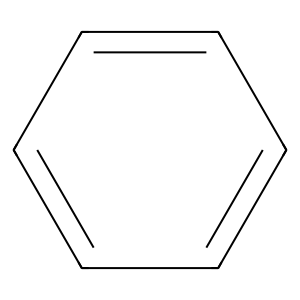

In [19]:
from rdkit import Chem
Chem.Draw.MolToImage(Chem.MolFromSmiles("C1=CC=CC=C1"))

In [21]:
# what is the path of python behind this notebook
import sys
sys.executable

'/home/xhajek9/miniconda3/envs/BARTtrain/bin/python'

In [25]:
import rdkit.Chem.Draw


In [27]:
from rdkit.Chem import Draw, MolFromSmiles

### Callback debug

In [30]:
from __future__ import annotations

import math
import pathlib
import shutil
from typing import Callable, Iterable

from tqdm.auto import tqdm
import pandas as pd
import transformers
import tokenizers
import wandb
import torch
import torch.utils.data
import warnings
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, MolFromSmiles, RDKFingerprint

In [34]:
pred_mol = Chem.MolFromSmiles("C1=CC=CC=C1")
type(pred_mol)

rdkit.Chem.rdchem.Mol

In [38]:
from callbacks import PredictionLogger # compute_cos_simils

ImportError: attempted relative import with no known parent package

In [45]:
a = {"a":2, "b":3}
x = a.get("c", None) 

In [46]:
x is None

True

In [149]:
transformers.Trainer()

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
Found safetensors installation, but --save_safetensors=False. Safetensors should be a preferred weights saving format due to security and performance reasons. If your model cannot be saved by safetensors please feel free to open an issue at https://github.com/huggingface/safetensors!
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


RuntimeError: `Trainer` requires either a `model` or `model_init` argument

In [125]:
from spectra_process_utils import msp_file_to_jsonl

msp_file_to_jsonl("data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-35_10.msp", 
                  "tokenizer/bbpe_tokenizer/bart_bbpe_1M_tokenizer.model",
                  source_token="<rassp>",
                  path_jsonl="data/datasets/30M_rassp/rassp_gen/TEST.jsonl", 
                  max_cumsum=0.995)

100%|██████████| 1000/1000 [00:00<00:00, 1197.74it/s]


0 no smiles
0 smiles too long
0 spectra corrupted
0 spectra w/ too high mz
13 spectra w/ too many peaks
totally 13 issues
discarded 13/1000 spectra 


In [123]:
from pathlib import Path
 
num_processes = 32
dir = "data/datasets/30M_rassp/rassp_gen/msps/"
files = list(Path(dir).glob("*"))
pad_len = num_processes - (len(files)%num_processes)
files += [None] * pad_len
grouped_files = np.array(files).reshape(32, -1)
# indexes = np.arange(len(files)).reshape(10, -1)
grouped_files

array([[PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-17_67.msp'),
        PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-36_43.msp'),
        PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-47_90.msp'),
        ...,
        PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-28_53.msp'),
        PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-21_17.msp'),
        PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-18_23.msp')],
       [PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-06_54.msp'),
        PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-15_11.msp'),
        PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-26_82.msp'),
        ...,
        PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-16_89.msp'),
        PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-43_49.msp'),
        PosixPath('data/datasets/30M_rassp/rassp_gen/msps/30M_rassp-44_73.msp')],


In [131]:
# split rassp dataset to train test valid
def data_split(df, train_test_valid_ratio: list):
    """split the df into train, test and valid sets"""
    if sum(train_test_valid_ratio) != 1:
        print("train_test_valid_ratio does not sum to 1")
        return None, None, None
    train_set = df.sample(
        frac=train_test_valid_ratio[0], random_state=42)
    rest = df.drop(train_set.index)

    test_set = rest.sample(frac=train_test_valid_ratio[1]/(train_test_valid_ratio[1]+train_test_valid_ratio[2]),
                           random_state=42)
    valid_set = rest.drop(test_set.index)
    print(f"train len: {len(train_set)}, test len: {len(test_set)}, valid len: {len(valid_set)}")
    return train_set, test_set, valid_set

In [127]:
df = pd.read_json("data/datasets/30M_rassp/rassp_gen/jsonls/all.jsonl", lines=True)

In [132]:
train, test, valid = data_split(df, [0.9, 0.05, 0.05])

train len: 4322581, test len: 240144, valid len: 240143


In [134]:
train.to_json("data/datasets/30M_rassp/rassp_gen/train.jsonl", orient="records", lines=True)
test.to_json("data/datasets/30M_rassp/rassp_gen/test.jsonl", orient="records", lines=True)
valid.to_json("data/datasets/30M_rassp/rassp_gen/valid.jsonl", orient="records", lines=True)

## NIST preprocess again (no overlaps in train - valid now)

In [7]:
from spectra_process_utils import msp_file_to_jsonl

dataset_path = Path("data/datasets/NIST/NIST_split_filip_no_overlap")
dataset_type = "test"
source_token = "<nist>"
msp_file_to_jsonl(dataset_path / f"{dataset_type}.msp",
                tokenizer_path,
                source_token,
                path_jsonl=dataset_path / f"{dataset_type}_{source_token}.jsonl"
                )

 12%|█▏        | 3284/26365 [00:01<00:12, 1792.52it/s]

Couldn't be canonicalized due to Exception: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType, bool)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)


100%|██████████| 26365/26365 [00:14<00:00, 1837.78it/s]


0 no smiles
48 smiles too long
1 spectra corrupted
697 spectra w/ too high mz
2267 spectra w/ too many peaks
totally 3013 issues
discarded 2693/26365 spectra 


In [ ]:
dataset_type = "train"
msp_file_to_jsonl(dataset_path / f"{dataset_type}.msp",
                tokenizer_path,
                source_token,
                path_jsonl=dataset_path / f"{dataset_type}_{source_token}.jsonl"
                )
dataset_type = "valid"
msp_file_to_jsonl(dataset_path / f"{dataset_type}.msp",
                tokenizer_path,
                source_token,
                path_jsonl=dataset_path / f"{dataset_type}_{source_token}.jsonl"
                )

In [18]:
import data_utils


In [19]:
data_utils

<module 'data' from '/home/xhajek9/gc-ms_bart/data.py'>

In [13]:
!ls data/smi_preprocess_neims.py

data/smi_preprocess_neims.py


In [14]:
from spectra_process_utils import msp_file_to_jsonl
from pathlib import Path

dataset_path = Path("data/datasets/NIST/NIST_split_filip_no_overlap")
dataset_type = "test"
source_token = "<nist>"
msp_file_to_jsonl(dataset_path / f"{dataset_type}.msp",
                Path(tokenizer_path),
                source_token,
                path_jsonl=dataset_path / f"{dataset_type}_{source_token}.jsonl",
                keep_spectra=True)

 12%|█▏        | 3235/26365 [00:01<00:14, 1613.31it/s]

Couldn't be canonicalized due to Exception: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType, bool)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)


100%|██████████| 26365/26365 [00:15<00:00, 1659.08it/s]


0 no smiles
48 smiles too long
1 spectra corrupted
697 spectra w/ too high mz
2267 spectra w/ too many peaks
totally 3013 issues
discarded 2693/26365 spectra 


In [15]:
dataset_type = "valid"
msp_file_to_jsonl(dataset_path / f"{dataset_type}.msp",
                Path(tokenizer_path),
                source_token,
                path_jsonl=dataset_path / f"{dataset_type}_{source_token}.jsonl",
                keep_spectra=True)

dataset_type = "train"
msp_file_to_jsonl(dataset_path / f"{dataset_type}.msp",
                Path(tokenizer_path),
                source_token,
                path_jsonl=dataset_path / f"{dataset_type}_{source_token}.jsonl",
                keep_spectra=True)

 87%|████████▋ | 22971/26493 [00:12<00:01, 1845.27it/s]

Couldn't be canonicalized due to Exception: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType, bool)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)


100%|██████████| 26493/26493 [00:14<00:00, 1823.63it/s]


0 no smiles
39 smiles too long
1 spectra corrupted
663 spectra w/ too high mz
2205 spectra w/ too many peaks
totally 2908 issues
discarded 2623/26493 spectra 


 17%|█▋        | 39290/237455 [00:21<01:53, 1752.12it/s][23:18:36] SMILES Parse Error: syntax error while parsing: [CH-]1|2C|3=C|4C|5=C1|[Fe]6789|2|3|4|5|[N-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10
[23:18:36] SMILES Parse Error: Failed parsing SMILES '[CH-]1|2C|3=C|4C|5=C1|[Fe]6789|2|3|4|5|[N-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10' for input: '[CH-]1|2C|3=C|4C|5=C1|[Fe]6789|2|3|4|5|[N-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10'
 17%|█▋        | 39670/237455 [00:22<01:48, 1820.55it/s]

Couldn't be canonicalized due to Exception: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType, bool)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)


 21%|██        | 48853/237455 [00:27<01:48, 1743.47it/s]

Couldn't be canonicalized due to Exception: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType, bool)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)


 22%|██▏       | 51235/237455 [00:28<01:43, 1806.21it/s]

Couldn't be canonicalized due to Exception: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType, bool)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)


 27%|██▋       | 64577/237455 [00:35<01:33, 1840.62it/s]

Couldn't be canonicalized due to Exception: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType, bool)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)


 28%|██▊       | 66772/237455 [00:37<01:37, 1755.08it/s]

Couldn't be canonicalized due to Exception: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType, bool)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)


 30%|██▉       | 71030/237455 [00:39<01:32, 1795.33it/s][23:18:53] SMILES Parse Error: syntax error while parsing: [CH-]1|2C|3=C|4C|5=C1|[Co]6789|2|3|4|5[CH-]%10B([CH-]6[CH-]7[CH-]8[CH-]9%10)c%11ccccc%11
[23:18:53] SMILES Parse Error: Failed parsing SMILES '[CH-]1|2C|3=C|4C|5=C1|[Co]6789|2|3|4|5[CH-]%10B([CH-]6[CH-]7[CH-]8[CH-]9%10)c%11ccccc%11' for input: '[CH-]1|2C|3=C|4C|5=C1|[Co]6789|2|3|4|5[CH-]%10B([CH-]6[CH-]7[CH-]8[CH-]9%10)c%11ccccc%11'
 30%|███       | 71389/237455 [00:39<01:35, 1741.70it/s]

Couldn't be canonicalized due to Exception: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType, bool)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)


 37%|███▋      | 87064/237455 [00:49<02:11, 1144.59it/s][23:19:04] SMILES Parse Error: syntax error while parsing: [CH-]1|2C|3=C|4C|5=C1|[Fe]6789|2|3|4|5|[N-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10
[23:19:04] SMILES Parse Error: Failed parsing SMILES '[CH-]1|2C|3=C|4C|5=C1|[Fe]6789|2|3|4|5|[N-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10' for input: '[CH-]1|2C|3=C|4C|5=C1|[Fe]6789|2|3|4|5|[N-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10'
 37%|███▋      | 87426/237455 [00:49<01:47, 1400.91it/s]

Couldn't be canonicalized due to Exception: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType, bool)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)


 37%|███▋      | 88170/237455 [00:50<01:26, 1733.38it/s][23:19:04] SMILES Parse Error: syntax error while parsing: [Ni]|1|2(|[S-]C(=C([S-]|1)c3ccccc3)c4ccccc4)|[S-]C(=C([S-]|2)c5ccccc5)c6ccccc6
[23:19:04] SMILES Parse Error: Failed parsing SMILES '[Ni]|1|2(|[S-]C(=C([S-]|1)c3ccccc3)c4ccccc4)|[S-]C(=C([S-]|2)c5ccccc5)c6ccccc6' for input: '[Ni]|1|2(|[S-]C(=C([S-]|1)c3ccccc3)c4ccccc4)|[S-]C(=C([S-]|2)c5ccccc5)c6ccccc6'
 37%|███▋      | 88544/237455 [00:50<01:23, 1774.03it/s]

Couldn't be canonicalized due to Exception: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType, bool)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)


 64%|██████▍   | 152614/237455 [01:25<00:46, 1834.74it/s]

Couldn't be canonicalized due to Exception: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType, bool)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)


 73%|███████▎  | 174104/237455 [01:37<00:34, 1841.16it/s]

Couldn't be canonicalized due to Exception: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType, bool)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)


 79%|███████▊  | 186739/237455 [01:44<00:28, 1777.47it/s]

Couldn't be canonicalized due to Exception: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType, bool)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)


 81%|████████  | 191781/237455 [01:47<00:24, 1845.61it/s]

Couldn't be canonicalized due to Exception: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType, bool)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)


 81%|████████▏ | 193086/237455 [01:48<00:24, 1786.03it/s]

Couldn't be canonicalized due to Exception: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType, bool)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)


 92%|█████████▏| 217318/237455 [02:01<00:10, 1867.02it/s][23:20:15] SMILES Parse Error: syntax error while parsing: [CH-]1|2C|3=C|4C|5=C1|[Mn]6789|2|3|4|5[CH-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10
[23:20:15] SMILES Parse Error: Failed parsing SMILES '[CH-]1|2C|3=C|4C|5=C1|[Mn]6789|2|3|4|5[CH-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10' for input: '[CH-]1|2C|3=C|4C|5=C1|[Mn]6789|2|3|4|5[CH-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10'
 92%|█████████▏| 217688/237455 [02:01<00:10, 1804.24it/s]

Couldn't be canonicalized due to Exception: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType, bool)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)


100%|██████████| 237455/237455 [02:12<00:00, 1791.73it/s]


0 no smiles
406 smiles too long
14 spectra corrupted
6004 spectra w/ too high mz
20226 spectra w/ too many peaks
totally 26650 issues
discarded 24049/237455 spectra 


In [19]:
import pandas as pd
pd.read_json("data/datasets/NIST/NIST_split_filip_no_overlap/valid.jsonl", lines=True)

,input_ids,position_ids,attention_mask,smiles,labels,decoder_attention_mask,mz,intensity
0,"[41, 44, 46, 50, 51, 52, 53, 61, 62, 63, 64, 6...","[0, 0, 0, 7, 7, 4, 0, 0, 4, 7, 6, 3, 0, 0, 4, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",O=[N+]([O-])c1cccc(N=Cc2ccccc2)c1,"[1234, 224, 50, 565, 49, 419, 50, 365, 70, 20,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[41.0, 44.0, 46.0, 50.0, 51.0, 52.0, 53.0, 61....","[1.0, 2.0, 4.0, 262.76, 326.71, 61.94, 5.0, 5...."
1,"[25, 26, 27, 28, 29, 30, 31, 38, 39, 40, 41, 4...","[1, 3, 7, 4, 8, 2, 1, 3, 8, 4, 9, 6, 9, 4, 5, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CCCCCCCCCCCCCC(C)OC(=O)c1cccs1,"[1234, 224, 1024, 487, 11, 38, 12, 286, 260, 5...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 38....","[11.99, 26.98, 290.74, 45.96, 474.57, 18.98, 1..."
2,"[27, 29, 30, 34, 39, 40, 41, 42, 43, 44, 51, 5...","[6, 7, 5, 0, 6, 0, 7, 5, 1, 6, 3, 0, 4, 1, 7, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CC=CC=CC=CN(CC)CC,"[1234, 224, 261, 32, 261, 32, 261, 32, 263, 11...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[27.0, 29.0, 30.0, 34.0, 39.0, 40.0, 41.0, 42....","[144.87, 283.74, 86.92, 7.99, 121.89, 0.5, 206..."
3,"[69, 75, 76, 77, 78, 98, 101, 102, 103, 104, 1...","[7, 5, 6, 6, 3, 4, 4, 6, 6, 4, 5, 8, 9, 8, 6, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CC(=O)N1c2ccccc2C=CC1C1C=Nc2ccccc2N1,"[1234, 224, 261, 260, 50, 12, 49, 20, 70, 21, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[69.0, 75.0, 76.0, 77.0, 78.0, 98.0, 101.0, 10...","[239.78, 79.93, 149.86, 159.86, 39.96, 49.95, ..."
4,"[27, 28, 29, 38, 39, 40, 41, 42, 51, 52, 53, 5...","[4, 6, 3, 2, 6, 5, 3, 2, 3, 4, 4, 6, 7, 2, 3, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CC1=CC(=O)C(N)=C(C)C1=O,"[1234, 224, 261, 20, 32, 261, 260, 50, 12, 38,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[27.0, 28.0, 29.0, 38.0, 39.0, 40.0, 41.0, 42....","[49.95, 136.88, 26.98, 23.98, 135.88, 76.93, 3..."
...,...,...,...,...,...,...,...,...
23865,"[15, 17, 18, 26, 27, 28, 29, 30, 31, 38, 39, 4...","[0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 2, 0, 4, 5, 6, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CCCCCOC(=O)CCCC(=O)OCc1ccc(OC)c([N+](=O)[O-])c1,"[1234, 224, 876, 260, 50, 12, 296, 260, 50, 12...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[15.0, 17.0, 18.0, 26.0, 27.0, 28.0, 29.0, 30....","[1.0, 1.0, 1.0, 1.0, 11.99, 8.99, 23.98, 2.0, ..."
23866,"[26, 27, 28, 29, 36, 38, 39, 40, 41, 42, 43, 4...","[0, 1, 1, 3, 0, 0, 2, 0, 5, 0, 3, 0, 0, 1, 3, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CC(C)(C)C1CCC(OC(=O)CCC(=O)OC2CCC(C(C)(C)C)CC2...,"[1234, 224, 261, 11, 38, 289, 38, 12, 38, 20, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[26.0, 27.0, 28.0, 29.0, 36.0, 38.0, 39.0, 40....","[2.0, 10.99, 11.99, 29.97, 7.99, 2.0, 16.98, 3..."
23867,"[15, 26, 27, 28, 29, 38, 39, 40, 41, 42, 43, 4...","[2, 1, 6, 3, 7, 1, 6, 2, 8, 3, 9, 3, 1, 1, 3, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",CCC(C)(C)C,"[1234, 224, 276, 11, 38, 289, 38, 12, 38, 0, -...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[15.0, 26.0, 27.0, 28.0, 29.0, 38.0, 39.0, 40....","[14.99, 11.99, 188.83, 24.98, 332.7, 9.99, 154..."
23868,"[2, 12, 13, 14, 15, 16, 17, 18, 19, 20, 24, 25...","[1, 1, 2, 4, 7, 0, 0, 0, 0, 0, 0, 1, 4, 7, 5, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",C=C(C)C(OC)OC(C)(C)C,"[1234, 224, 38, 32, 38, 11, 38, 12, 38, 11, 28...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0...","[10.99, 12.99, 18.98, 41.96, 217.8, 5.0, 3.0, ..."


## Rename a wandb group

In [20]:
import wandb
api = wandb.Api()
for r in api.runs("hajekad/BART_for_gcms", filters={"group": "finetune"}):
    r.group = "finetune_dataleak"
    r.update()

In [10]:
list(filter(lambda x: x.startswith("<"), list(tokenizer.vocab.keys())))

['<ukn>',
 '<pad>',
 '<nist>',
 '<rassp>',
 '<neims>',
 '<source2>',
 '<trafo>',
 '<source3>',
 '<bos>',
 '<',
 '<source1>',
 '<eos>']

In [20]:
from tokenizers import BaseTokenizer
tok = tokenizers.BaseTokenizer(vocab={"Dobry":3, "<unk>":0}, unk_token="<unk>")
tok.decode("Dobry den, jak se dneska asi mate?")

ImportError: cannot import name 'BaseTokenizer' from 'tokenizers' (/home/xhajek9/miniconda3/envs/BARTtrain/lib/python3.8/site-packages/tokenizers/__init__.py)

In [3]:
# check lens of arrays in rassp dataset
row = {"input_ids":[29,30,38,39,40,41,42,43,44,45,46,47,51,52,53,54,55,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,74,75,77,78,79,80,81,82,83,84,85,86,87,88,91,92,93,94,95,96,97,98,99,100,101,102,105,106,107,108,109,110,111,112,113,114,115,116,120,121,122,123,124,125,126,127,128,129,130,136,137,138,139,140,141,142,143,144,150,151,152,153,154,155,156,157,158,166,167,168,169,170,181,182,183,184,195,196,197,209,210,211,223,224,225,226,238,239,240,241,242,268,269,270,271,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2],"position_ids":[0,3,0,6,3,8,7,9,7,5,0,0,1,2,5,5,7,6,3,8,3,1,0,0,0,3,3,4,5,5,6,4,6,2,1,0,2,0,2,3,5,5,3,6,5,5,0,0,0,0,2,3,4,5,3,6,4,4,0,0,0,0,1,2,2,3,3,6,3,4,0,0,0,0,1,0,1,6,5,3,1,0,0,0,0,1,6,5,3,5,1,0,0,0,0,6,4,9,5,4,0,0,3,2,1,0,2,1,2,0,0,0,0,0,0,0,0,0,3,0,0,8,4,2,0,0,3,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1],"attention_mask":[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],"smiles":"CCCC(CC)(CN)CN(C)C(C)c1cscn1","labels":[1235,224,296,11,261,289,263,12,263,11,38,12,38,11,38,12,70,20,443,20,0,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100],"decoder_attention_mask":[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]}
sel_row = {"input_ids": [18, 27, 28, 29, 30, 32, 39, 41, 42, 43, 44, 45, 53, 54, 55, 56, 57, 59, 61, 67, 68, 69, 70, 73, 74, 75, 77, 79, 80, 81, 82, 83, 84, 94, 95, 96, 108, 109, 110, 111, 122, 123, 124, 125, 128, 129, 136, 138, 139, 140, 167, 196, 197, 198, 206, 207, 210, 211, 222, 224, 225, 226, 235, 236, 240, 249, 268, 269, 296, 299, 300, 301, 305, 307, 311, 312, 313, 379, 396, 407, 416, 417, 421, 422, 436, 437, 438, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], "position_ids": [2, 1, 6, 4, 1, 2, 2, 6, 5, 3, 3, 3, 2, 1, 7, 5, 1, 2, 1, 3, 2, 3, 3, 7, 4, 3, 2, 1, 2, 2, 3, 5, 1, 1, 3, 3, 3, 2, 5, 4, 1, 1, 3, 3, 1, 1, 1, 9, 6, 1, 1, 1, 1, 1, 3, 1, 2, 2, 1, 4, 3, 3, 1, 1, 1, 1, 1, 1, 2, 6, 4, 1, 1, 2, 5, 4, 1, 1, 1, 2, 3, 3, 4, 2, 7, 5, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], "attention_mask": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "smiles": "[C][C][C][C][N][C][C][C][Ring1][=Branch1][C][C][Ring1][=Branch1][C][Branch1][#Branch2][O][Si][Branch1][C][C][Branch1][C][C][C][C][=C][C][=N][C][=C][C][Branch1][=Branch2][C][Branch1][C][F][Branch1][C][F][F][=C][C][=C][Ring1][=C][Ring1][#Branch2]", "labels": [78, 57, 57, 57, 57, 64, 57, 57, 57, 71, 26, 57, 57, 71, 26, 57, 52, 7, 67, 1, 52, 57, 57, 52, 57, 57, 57, 57, 31, 57, 35, 57, 31, 57, 52, 27, 57, 52, 57, 59, 52, 57, 59, 59, 31, 57, 31, 71, 31, 71, 7, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100], "decoder_attention_mask": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "mz": [18.0, 27.0, 28.0, 29.0, 30.0, 32.0, 39.0, 41.0, 42.0, 43.0, 44.0, 45.0, 53.0, 54.0, 55.0, 56.0, 57.0, 59.0, 61.0, 67.0, 68.0, 69.0, 70.0, 73.0, 74.0, 75.0, 77.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 94.0, 95.0, 96.0, 108.0, 109.0, 110.0, 111.0, 122.0, 123.0, 124.0, 125.0, 128.0, 129.0, 136.0, 138.0, 139.0, 140.0, 167.0, 196.0, 197.0, 198.0, 206.0, 207.0, 210.0, 211.0, 222.0, 224.0, 225.0, 226.0, 235.0, 236.0, 240.0, 249.0, 268.0, 269.0, 296.0, 299.0, 300.0, 301.0, 305.0, 307.0, 311.0, 312.0, 313.0, 379.0, 396.0, 407.0, 416.0, 417.0, 421.0, 422.0, 436.0, 437.0, 438.0], "intensity": [23.98, 13.99, 120.89, 51.95, 13.99, 17.98, 18.98, 134.88, 93.92, 31.97, 24.98, 39.96, 18.98, 12.99, 250.77, 83.92, 12.99, 18.98, 10.99, 30.97, 20.98, 40.96, 31.97, 331.7, 43.96, 38.96, 18.98, 11.99, 14.99, 15.99, 36.97, 72.93, 10.99, 12.99, 25.98, 24.98, 39.96, 14.99, 107.9, 47.96, 11.99, 11.99, 32.97, 26.98, 12.99, 9.99, 12.99, 999.0, 129.88, 10.99, 13.99, 9.99, 10.99, 10.99, 29.97, 9.99, 15.99, 20.98, 10.99, 49.95, 28.97, 29.97, 10.99, 12.99, 10.99, 12.99, 13.99, 9.99, 18.98, 179.84, 47.96, 12.99, 11.99, 15.99, 103.91, 48.96, 9.99, 13.99, 11.99, 17.98, 24.98, 24.98, 58.95, 16.98, 239.78, 77.93, 20.98]}
print(len(row["input_ids"]), len(sel_row["input_ids"]))
print(len(row["position_ids"]), len(sel_row["position_ids"]))
print(len(row["attention_mask"]), len(sel_row["attention_mask"]))
print(len(row["decoder_attention_mask"]), len(sel_row["decoder_attention_mask"]))
print(len(row["labels"]), len(sel_row["labels"]))


200 200
200 200
200 200
200 200
200 200


## Debug pushing SELFIES data to the model

In [18]:
from data_utils import SpectroDataset, SpectroDataCollator, load_all_datapipes, build_single_datapipe
from bart_spektro.modeling_bart_spektro import BartSpektroForConditionalGeneration
from bart_spektro.configuration_bart_spektro import BartSpektroConfig
from bart_spektro.selfies_tokenizer import hardcode_build_selfies_tokenizer
from tokenizers import Tokenizer
from torch.utils.data import DataLoader
from icecream import ic

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
model_args = {"tokenizer_path": "selfies_tokenizer", # not a path just for the trainer to know it should use sefies tokenizer 
            "seq_len": 200,   # !!!!!!!
            "encoder_layers": 12, # 24
            "encoder_ffn_dim": 4096,
            "encoder_attention_heads": 16,
            "decoder_layers": 12, # 24
            "decoder_ffn_dim": 4096,
            "decoder_attention_heads": 16}

In [23]:
tokenizer = hardcode_build_selfies_tokenizer()
config = BartSpektroConfig(vocab_size=len(tokenizer.get_vocab()),
                            max_mz=499,
                            max_position_embeddings=model_args["seq_len"],
                            max_length=model_args["seq_len"],
                            tie_word_embeddings=False,
                            min_len=0,
                            encoder_layers=model_args["encoder_layers"],
                            encoder_ffn_dim=model_args["encoder_ffn_dim"],
                            encoder_attention_heads=model_args["encoder_attention_heads"],
                            decoder_layers=model_args["decoder_layers"],
                            decoder_ffn_dim=model_args["decoder_ffn_dim"],
                            decoder_attention_heads=model_args["decoder_attention_heads"],
                            encoder_layerdrop=0.0,
                            decoder_layerdrop=0.0,
                            activation_function='gelu',
                            d_model=1024,
                            dropout=0.2,
                            attention_dropout=0.0,
                            activation_dropout=0.0,
                            init_std=0.02,
                            classifier_dropout=0.0,
                            scale_embedding=False,
                            use_cache=True,
                            pad_token_id=2,
                            bos_token_id=3,
                            eos_token_id=0,
                            is_encoder_decoder=True,
                            decoder_start_token_id=3,
                            forced_eos_token_id=0,
                            max_log_id=9)

In [24]:
model = BartSpektroForConditionalGeneration(config)
model.to("cpu")
None

In [25]:
model.lm_head.weight.shape, model.config.vocab_size

(torch.Size([85, 1024]), 85)

In [26]:
data = build_single_datapipe("data/datasets/NIST/NIST_split_filip/sel_train.jsonl")
None

In [27]:
loader = DataLoader(data, batch_size=128, collate_fn=SpectroDataCollator())

In [36]:
for i, batch in enumerate(loader):
    # if i > 434:
    #   break
    # if i < 430:
    #   continue
    ic(i, batch["input_ids"].max(), batch["input_ids"].min())
    # ic(batch)
    assert batch["input_ids"].shape[1] == model_args["seq_len"], f"{batch['input_ids'].shape[1]} != {model_args['seq_len']}"
    assert batch["attention_mask"].shape[1] == model_args["seq_len"], f"{batch['attention_mask'].shape[1]} != {model_args['seq_len']}"
    assert batch["decoder_attention_mask"].shape[1] == model_args["seq_len"], f"{batch['decoder_attention_mask'].shape[1]} != {model_args['seq_len']}"
    assert batch["input_ids"].max() < 501, f"{batch['input_ids'].max()} >= {501} \n {batch['input_ids']}"
    assert batch["input_ids"].min() >= 0, f"{batch['input_ids'].min()} < 0"
    # model(input_ids=batch["input_ids"],
    #       attention_mask=batch["attention_mask"],
    #       decoder_attention_mask=batch["decoder_attention_mask"],
    #       labels=batch["labels"],
    #       position_ids=batch["position_ids"])
    

ic| i: 0
    batch["input_ids"].max(): tensor(469)
    batch["input_ids"].min(): tensor(2)
ic| i: 1
    batch["input_ids"].max(): tensor(472)
    batch["input_ids"].min(): tensor(2)
ic| i: 2
    batch["input_ids"].max(): tensor(495)
    batch["input_ids"].min(): tensor(1)
ic| i: 3
    batch["input_ids"].max(): tensor(455)
    batch["input_ids"].min(): tensor(2)


ic| i: 4
    batch["input_ids"].max(): tensor(436)
    batch["input_ids"].min(): tensor(2)
ic| i: 5
    batch["input_ids"].max(): tensor(494)
    batch["input_ids"].min(): tensor(2)
ic| i: 6
    batch["input_ids"].max(): tensor(467)
    batch["input_ids"].min(): tensor(2)
ic| i: 7
    batch["input_ids"].max(): tensor(475)
    batch["input_ids"].min(): tensor(2)
ic| i: 8
    batch["input_ids"].max(): tensor(461)
    batch["input_ids"].min(): tensor(2)
ic| i: 9
    batch["input_ids"].max(): tensor(474)
    batch["input_ids"].min(): tensor(2)
ic| i: 10
    batch["input_ids"].max(): tensor(496)
    batch["input_ids"].min(): tensor(2)
ic| i: 11
    batch["input_ids"].max(): tensor(489)
    batch["input_ids"].min(): tensor(2)
ic| i: 12
    batch["input_ids"].max(): tensor(470)
    batch["input_ids"].min(): tensor(2)
ic| i: 13
    batch["input_ids"].max(): tensor(406)
    batch["input_ids"].min(): tensor(2)
ic| i: 14
    batch["input_ids"].max(): tensor(496)
    batch["input_ids"].min(): tens

KeyboardInterrupt: 

In [13]:
for batch in loader:
    if (batch["labels"] > 84).any():
        print(batch["labels"])

## check if embeddings for first n tokens are common

In [139]:
model = BartSpektroForConditionalGeneration.from_pretrained("checkpoints/bart_2023-04-07-18_27_23_30Mneims/checkpoint-1680000/")


In [66]:
model.model.encoder.embed_tokens.weight.data[0:800] == model.model.decoder.embed_tokens.weight.data[0:800] 

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [138]:
hasattr(config, "mz_ins")

False